In [765]:
print("Detecting anomalies in medical claims data")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

Detecting anomalies in medical claims data


In [766]:
df = pd.read_csv("./Healthcare Providers.csv")
df.head()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,SAINT LOUIS,631041004.0,MO,US,Internal Medicine,Y,F,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,FAYETTEVILLE,283043815.0,NC,US,Obstetrics & Gynecology,Y,O,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,NORTH HAVEN,64732343.0,CT,US,Podiatry,Y,O,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,KANSAS CITY,641183998.0,MO,US,Internal Medicine,Y,O,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,JUPITER,334585700.0,FL,US,Internal Medicine,Y,O,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


In [767]:
max_row_index = df['Number of Services'].idxmax()
max_row = df.loc[max_row_index]

print(max_row)

index                                                                              4337700
National Provider Identifier                                                    1447206933
Last Name/Organization Name of the Provider                                        RUSSELL
First Name of the Provider                                                         RAYMOND
Middle Initial of the Provider                                                           S
Credentials of the Provider                                                           M.D.
Gender of the Provider                                                                   M
Entity Type of the Provider                                                              I
Street Address 1 of the Provider                            4000 MIAMISBURG CENTERVILLE RD
Street Address 2 of the Provider                                                 SUITE 405
City of the Provider                                                            MIAMISBURG

In [768]:
df.columns

Index(['index', 'National Provider Identifier',
       'Last Name/Organization Name of the Provider',
       'First Name of the Provider', 'Middle Initial of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'Street Address 1 of the Provider',
       'Street Address 2 of the Provider', 'City of the Provider',
       'Zip Code of the Provider', 'State Code of the Provider',
       'Country Code of the Provider', 'Provider Type',
       'Medicare Participation Indicator', 'Place of Service', 'HCPCS Code',
       'HCPCS Description', 'HCPCS Drug Indicator', 'Number of Services',
       'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',
       'Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount'],
      dtype='object')

In [769]:
DropCols = ['Last Name/Organization Name of the Provider',
       'First Name of the Provider', 'Middle Initial of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'Street Address 1 of the Provider',
       'Street Address 2 of the Provider', 'City of the Provider',
        'State Code of the Provider',
       'Country Code of the Provider', 'Provider Type',
       'Medicare Participation Indicator', 'Place of Service', 'HCPCS Drug Indicator', 
       'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',
       'Average Medicare Allowed Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount']

df = df.drop(DropCols, axis = 1)

In [770]:
df.columns

Index(['index', 'National Provider Identifier', 'Zip Code of the Provider',
       'HCPCS Code', 'HCPCS Description', 'Number of Services',
       'Average Submitted Charge Amount'],
      dtype='object')

In [771]:
df.shape

(100000, 7)

In [772]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   index                            100000 non-null  int64  
 1   National Provider Identifier     100000 non-null  int64  
 2   Zip Code of the Provider         100000 non-null  float64
 3   HCPCS Code                       100000 non-null  object 
 4   HCPCS Description                100000 non-null  object 
 5   Number of Services               100000 non-null  object 
 6   Average Submitted Charge Amount  100000 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 5.3+ MB


In [773]:
#Check for missing values
df.isnull().sum()

index                              0
National Provider Identifier       0
Zip Code of the Provider           0
HCPCS Code                         0
HCPCS Description                  0
Number of Services                 0
Average Submitted Charge Amount    0
dtype: int64

In [774]:
def RemoveComma(x):
    return x.replace(",","")

df["Average Submitted Charge Amount"] = pd.to_numeric(df["Average Submitted Charge Amount"].apply(lambda x: RemoveComma(x)),
                                                             errors= "ignore")

In [775]:
df.describe()

,index,National Provider Identifier,Zip Code of the Provider,Average Submitted Charge Amount
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,4.907646e+06,1.498227e+09,4.163820e+08,354.550451
std,2.839633e+06,2.874125e+08,3.082566e+08,1062.608271
min,2.090000e+02,1.003001e+09,6.010000e+02,0.010000
25%,2.458791e+06,1.245669e+09,1.426300e+08,57.647876
50%,4.901266e+06,1.497847e+09,3.633025e+08,146.000000
75%,7.349450e+06,1.740374e+09,6.819881e+08,298.932111
max,9.847440e+06,1.993000e+09,9.990166e+08,62694.000000


In [776]:
df.head()

,index,National Provider Identifier,Zip Code of the Provider,HCPCS Code,HCPCS Description,Number of Services,Average Submitted Charge Amount
0,8774979,1891106191,631041004.0,99223,"Initial hospital inpatient care, typically 70 ...",27,305.211111
1,3354385,1346202256,283043815.0,G0202,"Screening mammography, bilateral (2-view study...",175,548.800000
2,3001884,1306820956,64732343.0,99348,"Established patient home visit, typically 25 m...",32,155.000000
3,7594822,1770523540,641183998.0,81002,"Urinalysis, manual test",20,5.000000
4,746159,1073627758,334585700.0,96372,Injection beneath the skin or into muscle for ...,33,40.000000


In [777]:
#Checking categorical attributes
df['HCPCS Code'].unique()

array(['99223', 'G0202', '99348', ..., '43247', '33530', '52001'],
      dtype=object)

In [778]:
len(df['HCPCS Code'].unique())

2631

In [779]:
#Checking categorical attributes
df['National Provider Identifier'].unique()

array([1891106191, 1346202256, 1306820956, ..., 1215091327, 1891941183,
       1356772156])

In [780]:
len(df['National Provider Identifier'].unique())

89508

In [781]:
#Checking categorical attributes
df['Zip Code of the Provider'].unique()

array([6.31041004e+08, 2.83043815e+08, 6.47323430e+07, ...,
       6.04811236e+08, 9.77561502e+08, 1.10230000e+04])

In [782]:
len(df['Zip Code of the Provider'].unique())

47827

In [783]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   index                            100000 non-null  int64  
 1   National Provider Identifier     100000 non-null  int64  
 2   Zip Code of the Provider         100000 non-null  float64
 3   HCPCS Code                       100000 non-null  object 
 4   HCPCS Description                100000 non-null  object 
 5   Number of Services               100000 non-null  object 
 6   Average Submitted Charge Amount  100000 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.3+ MB


In [784]:
def RemoveComma(x):
    return x.replace(",","")

df["Number of Services"] = pd.to_numeric(df["Number of Services"].apply(lambda x: RemoveComma(x)),
                                                             errors= "ignore")
df['Number of Services'] = df['Number of Services'].astype(float)

In [785]:
#df['HCPCS Code'] = pd.to_numeric(df['HCPCS Code'], errors='coerce')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['HCPCS Code'] = le.fit_transform(df['HCPCS Code'])

df['HCPCS Code'] = df['HCPCS Code'].astype(float)


In [786]:
len(df['HCPCS Code'].unique())

2631

In [787]:
df.head()

,index,National Provider Identifier,Zip Code of the Provider,HCPCS Code,HCPCS Description,Number of Services,Average Submitted Charge Amount
0,8774979,1891106191,631041004.0,2251.0,"Initial hospital inpatient care, typically 70 ...",27.0,305.211111
1,3354385,1346202256,283043815.0,2374.0,"Screening mammography, bilateral (2-view study...",175.0,548.800000
2,3001884,1306820956,64732343.0,2295.0,"Established patient home visit, typically 25 m...",32.0,155.000000
3,7594822,1770523540,641183998.0,1329.0,"Urinalysis, manual test",20.0,5.000000
4,746159,1073627758,334585700.0,2163.0,Injection beneath the skin or into muscle for ...,33.0,40.000000


In [788]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   index                            100000 non-null  int64  
 1   National Provider Identifier     100000 non-null  int64  
 2   Zip Code of the Provider         100000 non-null  float64
 3   HCPCS Code                       100000 non-null  float64
 4   HCPCS Description                100000 non-null  object 
 5   Number of Services               100000 non-null  float64
 6   Average Submitted Charge Amount  100000 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 5.3+ MB


In [789]:
#Updating X with only numerics
df = df[['Average Submitted Charge Amount','Number of Services','HCPCS Code']]                                                   

In [790]:
df.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code
0,305.211111,27.0,2251.0
1,548.800000,175.0,2374.0
2,155.000000,32.0,2295.0
3,5.000000,20.0,1329.0
4,40.000000,33.0,2163.0


In [791]:
# Create cluster feature
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
df["Cluster"] = kmeans.fit_predict(df)
df["Cluster"] = df["Cluster"].astype("category")

df.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
0,305.211111,27.0,2251.0,2
1,548.800000,175.0,2374.0,2
2,155.000000,32.0,2295.0,2
3,5.000000,20.0,1329.0,2
4,40.000000,33.0,2163.0,2


In [792]:
df['Cluster'].unique()

[2, 0, 1, 3]
Categories (4, int32): [0, 1, 2, 3]

In [793]:
# Count unique values in the 'Category' column
value_counts = df['Cluster'].value_counts().reset_index()

# Rename columns
value_counts.columns = ['Unique_Value', 'Count']

# Display the resulting DataFrame
print(value_counts)

  Unique_Value  Count
0            2  69211
1            0  30636
2            1    144
3            3      9


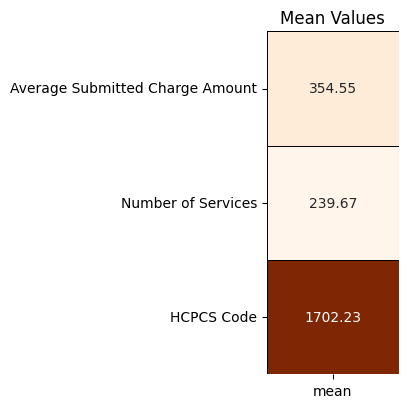

In [795]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))

colors = ['#FF781F','#2D2926']
plt.subplot(1,1,1)
sns.heatmap(df.describe().T[['mean']],cmap = 'Oranges',annot = True,fmt = '.2f',linecolor = 'black',linewidths = 0.4,cbar = False);
plt.title('Mean Values');

fig.tight_layout(pad = 4)

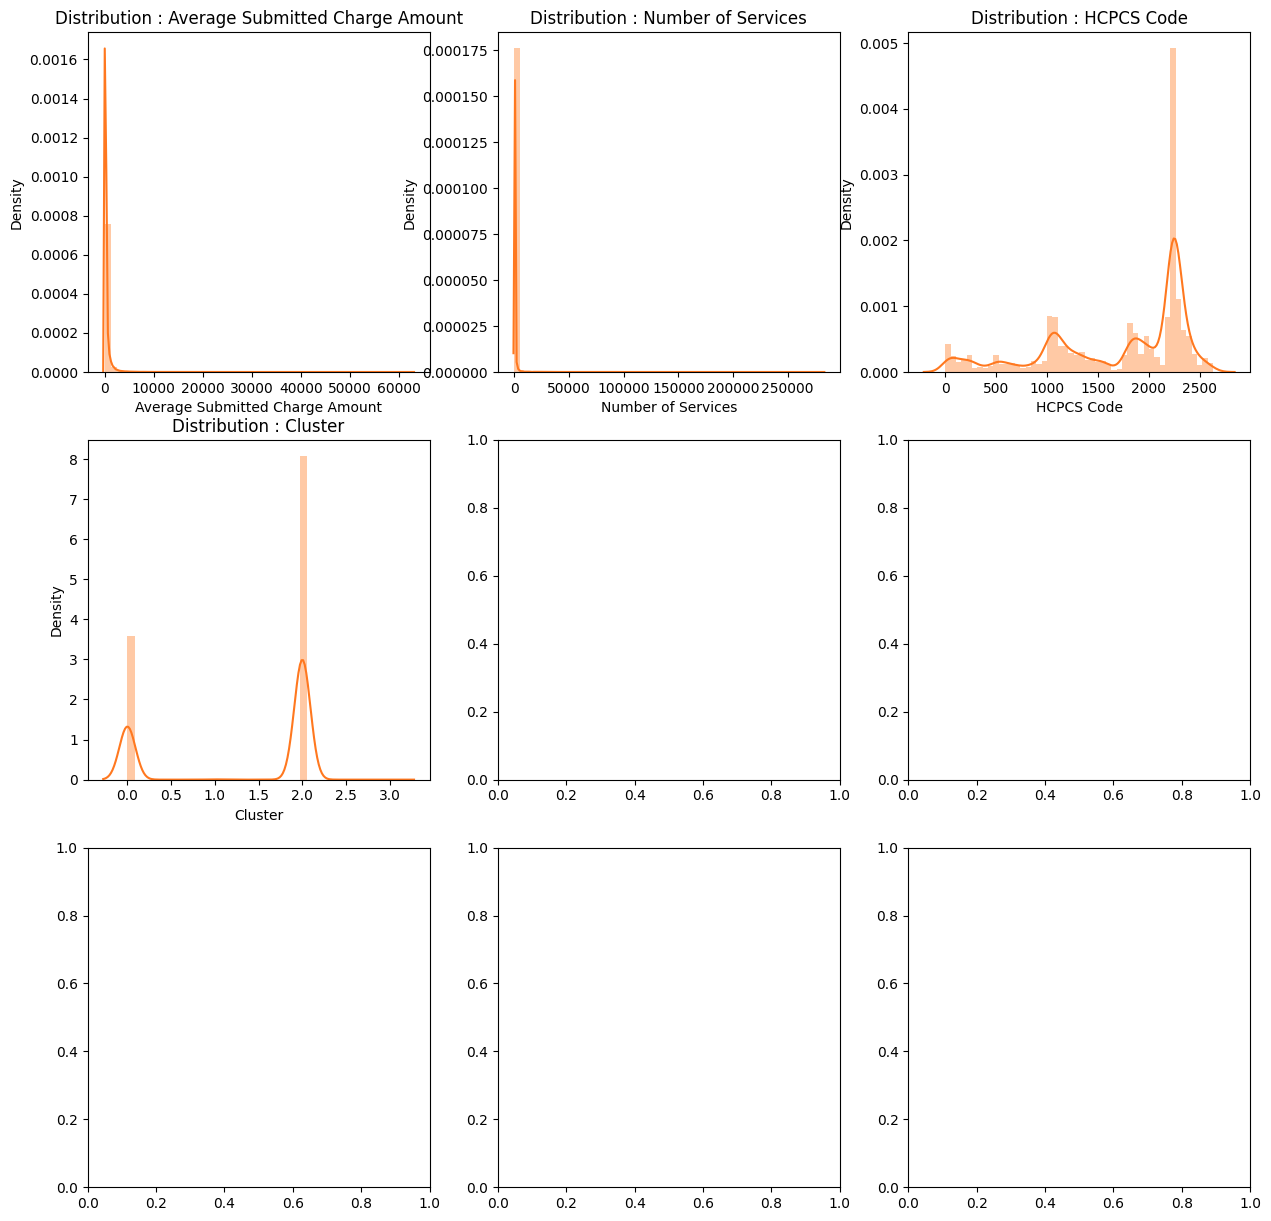

In [797]:
col = list(df.columns)
numerical_features = [*col]

fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.distplot(df[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

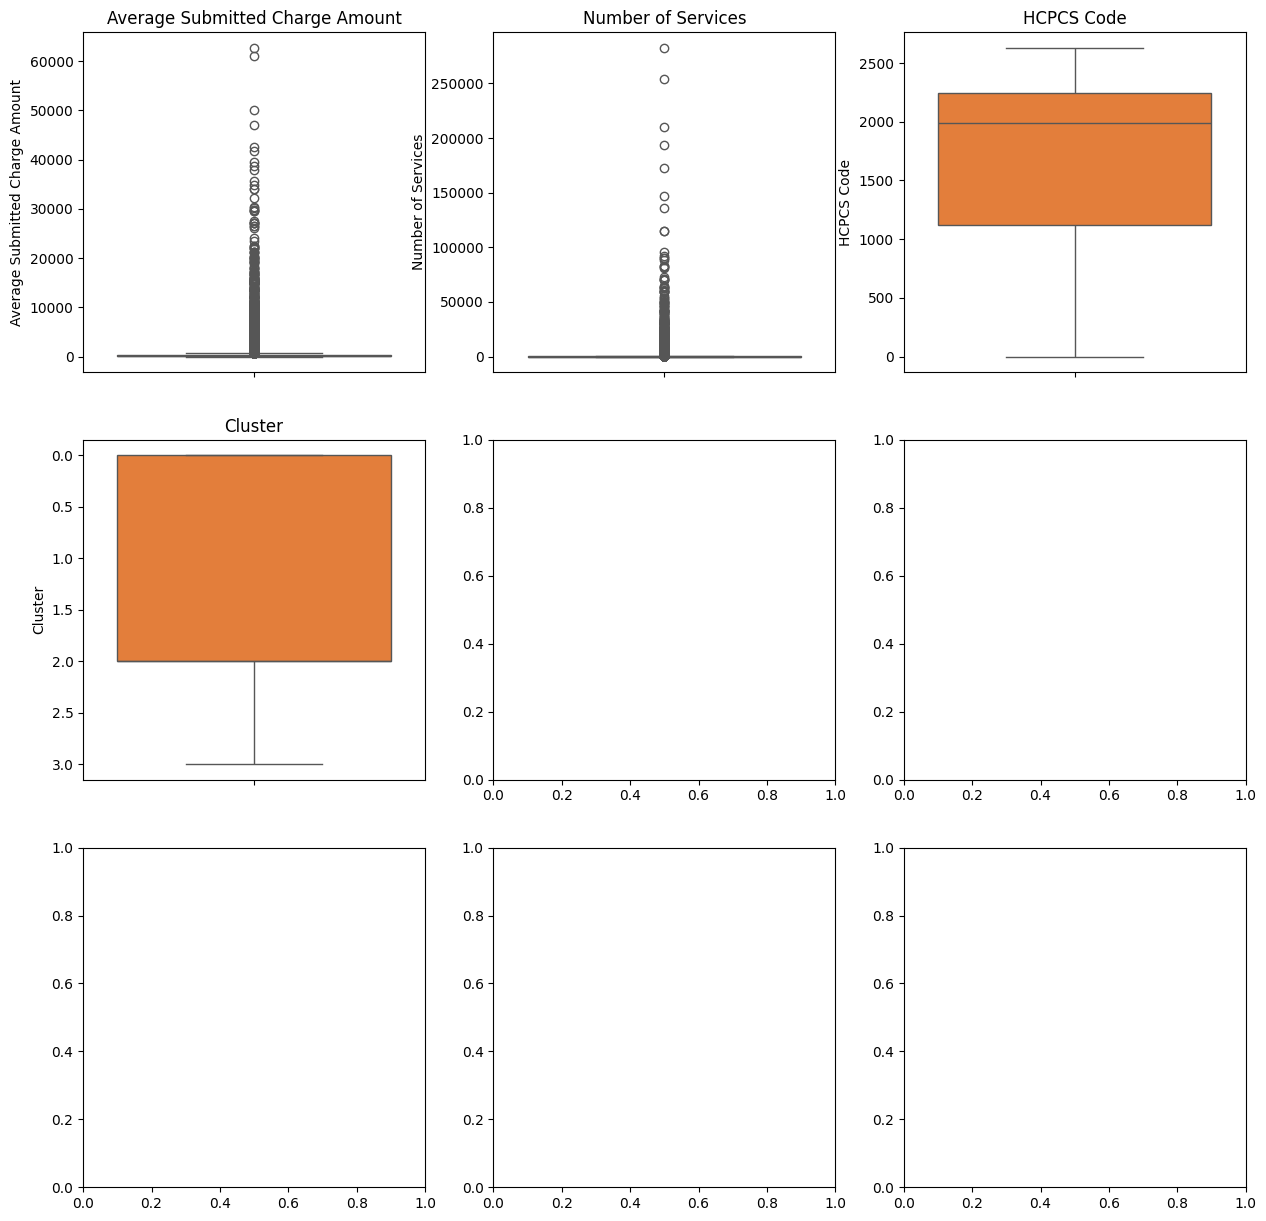

In [798]:
fig  = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(df[numerical_features[i]],color = colors[0])
    plt.title(numerical_features[i])
plt.show()


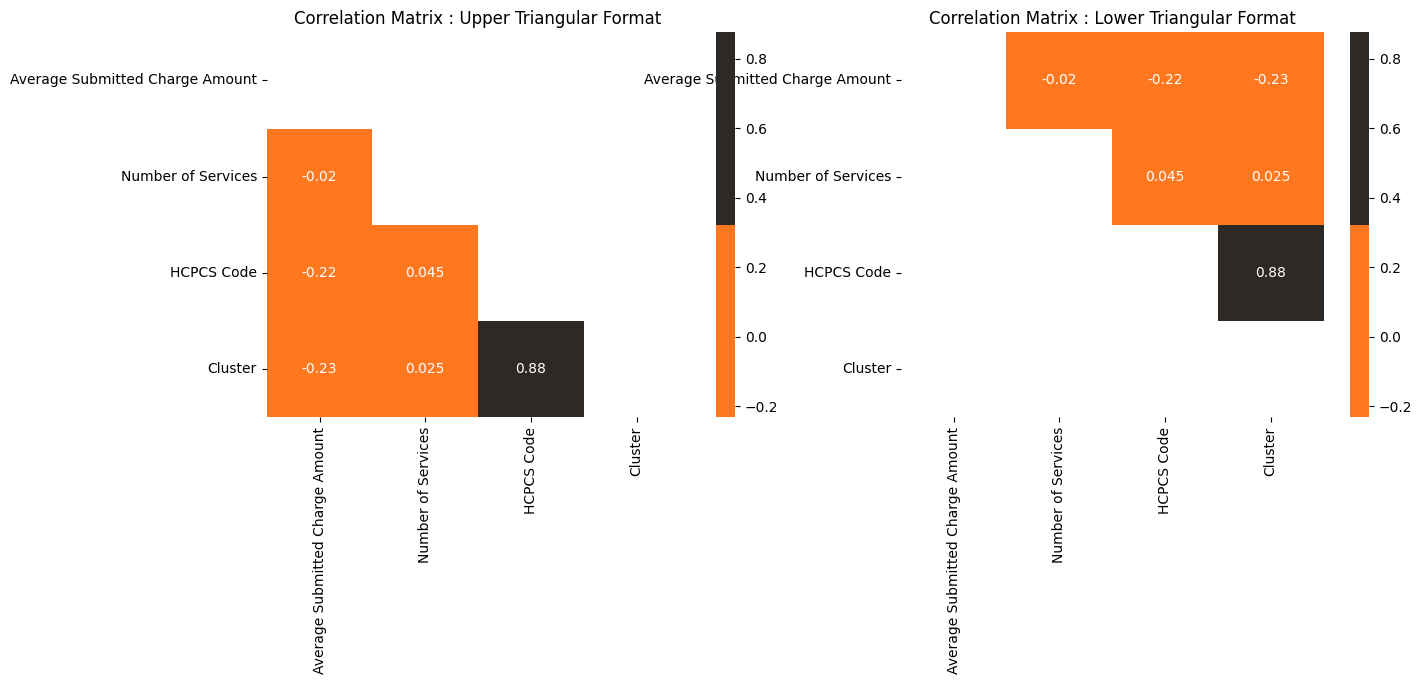

In [799]:
ut = np.triu(df.corr())
lt = np.tril(df.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(df.corr(),cmap = colors,annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(df.corr(),cmap = colors,annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

In [800]:
df.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
0,305.211111,27.0,2251.0,2
1,548.800000,175.0,2374.0,2
2,155.000000,32.0,2295.0,2
3,5.000000,20.0,1329.0,2
4,40.000000,33.0,2163.0,2


In [801]:
kmeans.cluster_centers_

array([[7.24726031e+02, 8.48925774e+01, 7.76311203e+02],
       [1.75782838e+01, 3.79415326e+04, 2.37588194e+03],
       [1.91435593e+02, 2.06274214e+02, 2.11064977e+03],
       [3.98102555e+01, 1.80705344e+05, 1.90411111e+03]])

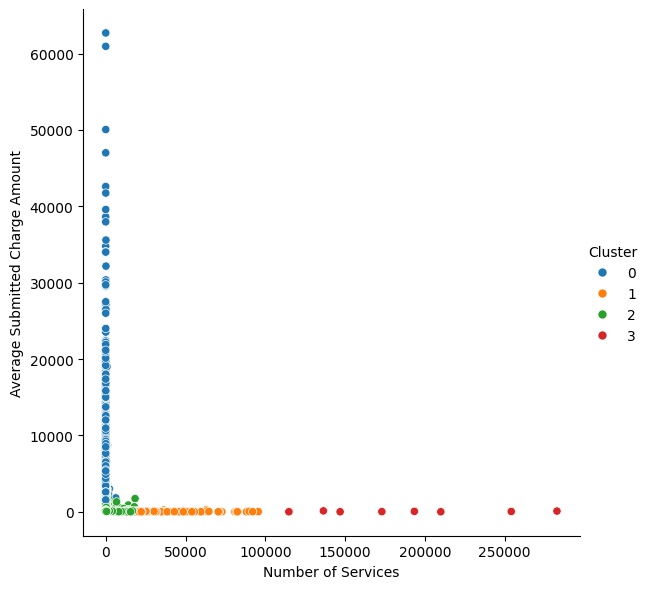

In [802]:
sns.relplot(
    x="Number of Services", y="Average Submitted Charge Amount",  hue="Cluster", data=df, height=6,
);

In [803]:
data1 = df[df.Cluster==0]
data2 = df[df.Cluster==1]
data3 = df[df.Cluster==2]
data4 = df[df.Cluster==3]

In [804]:
data1.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
6,164.571429,21.0,258.0,0
11,43.000000,20.0,1112.0,0
12,38.380952,21.0,1052.0,0
15,272.000000,23.0,1022.0,0
19,302.500000,61.0,1151.0,0


In [805]:
data2.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
563,0.130000,70700.0,2468.0,1
609,25.735085,44965.0,2353.0,1
1123,15.000000,24776.0,2507.0,1
1405,2.700000,19950.0,2476.0,1
1939,0.131899,24490.0,2627.0,1


In [806]:
data3.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
0,305.211111,27.0,2251.0,2
1,548.800000,175.0,2374.0,2
2,155.000000,32.0,2295.0,2
3,5.000000,20.0,1329.0,2
4,40.000000,33.0,2163.0,2


In [807]:
data4.head()

,Average Submitted Charge Amount,Number of Services,HCPCS Code,Cluster
2491,17.616511,173026.1,2313.0,3
12651,28.535681,115109.0,1691.0,3
58126,118.503336,136388.0,1324.0,3
77440,53.889438,193400.0,1401.0,3
81966,2.000000,114750.0,2603.0,3


In [817]:
kmeans.cluster_centers_

array([[7.24726031e+02, 8.48925774e+01, 7.76311203e+02],
       [1.75782838e+01, 3.79415326e+04, 2.37588194e+03],
       [1.91435593e+02, 2.06274214e+02, 2.11064977e+03],
       [3.98102555e+01, 1.80705344e+05, 1.90411111e+03]])

In [822]:
kmeans.cluster_centers_[:,2]

array([ 776.31120251, 2375.88194444, 2110.64976666, 1904.11111111])

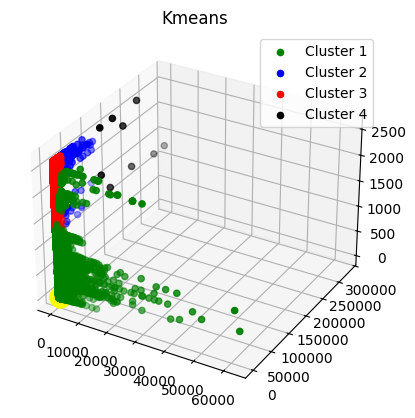

In [ ]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
kplot.plot3D(xline, yline, zline, 'black')
# Data for three-dimensional scattered points
kplot.scatter3D(data1['Average Submitted Charge Amount'],data1['Number of Services'], data1['HCPCS Code'], c='green', label = 'Cluster 1')
kplot.scatter3D(data2['Average Submitted Charge Amount'],data2['Number of Services'], data2['HCPCS Code'], c='blue', label = 'Cluster 2')
kplot.scatter3D(data3['Average Submitted Charge Amount'],data3['Number of Services'], data3['HCPCS Code'], c='red', label = 'Cluster 3')
kplot.scatter3D(data4['Average Submitted Charge Amount'],data4['Number of Services'], data4['HCPCS Code'], c='black', label = 'Cluster 4')
kplot.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], color = 'yellow', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()

In [617]:
df['Number of Services'].max()

np.float64(282739.0)

In [612]:
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans

cluster = km.cluster_centers_
centroids = np.array(cluster)

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Number of Services'],
        y = db[db['Cluster']==n]['HCPCS Code'],
        z = db[db['Cluster']==n]['Average Submitted Charge Amount'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(km, 0, 'Cluster 0')
trace1 = tracer(km, 1, 'Cluster 1')
trace2 = tracer(km, 2, 'Cluster 2')

data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Number of Services'),
            yaxis = dict(title = 'HCPCS Code'),
            zaxis = dict(title = 'Average Submitted Charge Amount')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

TypeError: 'KMeans' object is not subscriptable

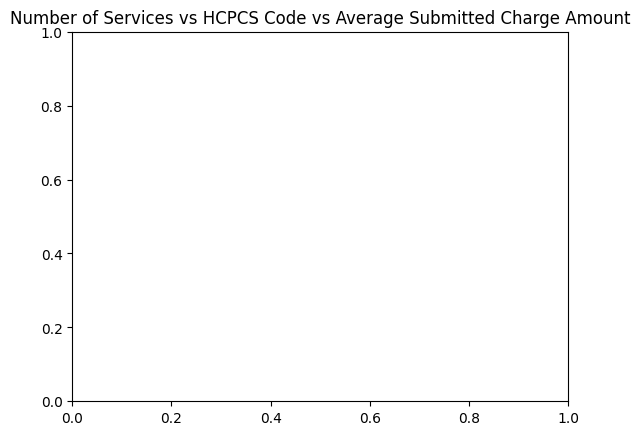

In [502]:
from mpl_toolkits.mplot3d import Axes3D

model = KMeans(n_clusters = 2,max_iter = 1000)
model.fit(df)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
df['Class'] = labels; 

fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df['Number of Services'])
y = np.array(df['HCPCS Code'])
z = np.array(df['Average Submitted Charge Amount'])
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
ax.scatter(x,y,z,c = y)
plt.title('Number of Services vs HCPCS Code vs Average Submitted Charge Amount')
ax.set_xlabel('Number of Services')
ax.set_ylabel('HCPCS Code')
ax.set_zlabel('Average Submitted Charge Amount')
plt.show();

In [ ]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df)
    labels = kmeans.labels_
    sil.append(silhouette_score(df, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()